#Sukeliame train data bei visus import

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt

with gzip.open('flatland_train.data', 'rb') as f:
    X, y = pickle.load(f)

print(X.shape, y.shape)

(10000, 50, 50) (10000,)


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Klasė naudojama datasetui
X nuotraukom ir y label
lnit inicializuoja dataseta galima pasirinkti ar veliau dar bus ir transform.

len returnina dataseto ilgį

getitem duoda atgal nuotrauka

Naudojamas pil image kad butu galima transforminti

Returnina nuotrauka ir jos label

In [ ]:
class FlatlandDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        image = Image.fromarray(np.uint8(image * 255))

        if self.transform:
            image = self.transform(image)

        return image, label

# Transform
Transfrom naudingas tam, nes jis suteikiamas nuotraukai, kai ji paemama iš dataseto ir tai padeda modeliui su training datos įvairumu.


In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(50, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

flatland_dataset = FlatlandDataset(X, y, transform=transform)

# CNN modelis
Mano modelis naudoja 3 conv layers, 2 fully connected layers kalsifikavimui bei turi 7 klases.

In [ ]:
from arch import CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# CNN modelio treniravimas
Naudojamos train_model ir validate_model funkcijos. Epochos metu skaičiuojamas train loss bei train accuracy. Validation accuracy naudojamas, jog pažiūrėt kaip teisingai atspėja naujus duomenis.Train size yra 0.8, o validation 0.2 dataseto.

Optimizavimui naudojamas Adam optimizeris, CrossEntropyLoss kriterijus, kuris viduje taip pat naudoja softmax.

In [ ]:
from utils import train_model, validate_model
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(flatland_dataset))
val_size = len(flatland_dataset) - train_size

train_dataset, val_dataset = random_split(flatland_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train_model(model, train_loader, optimizer, criterion, num_epochs=75, device=device)

validate_model(model, val_loader, criterion, device=device)

Epoch 1/3, Train Loss: 0.1232, Train Accuracy: 0.9810
Epoch 2/3, Train Loss: 0.1234, Train Accuracy: 0.9802
Epoch 3/3, Train Loss: 0.1160, Train Accuracy: 0.9818
Training complete!
Validation Loss: 0.1672, Validation Accuracy: 0.9765


#Su saliency matom, kokios nuotraukų dalys svarbiausios modeliui

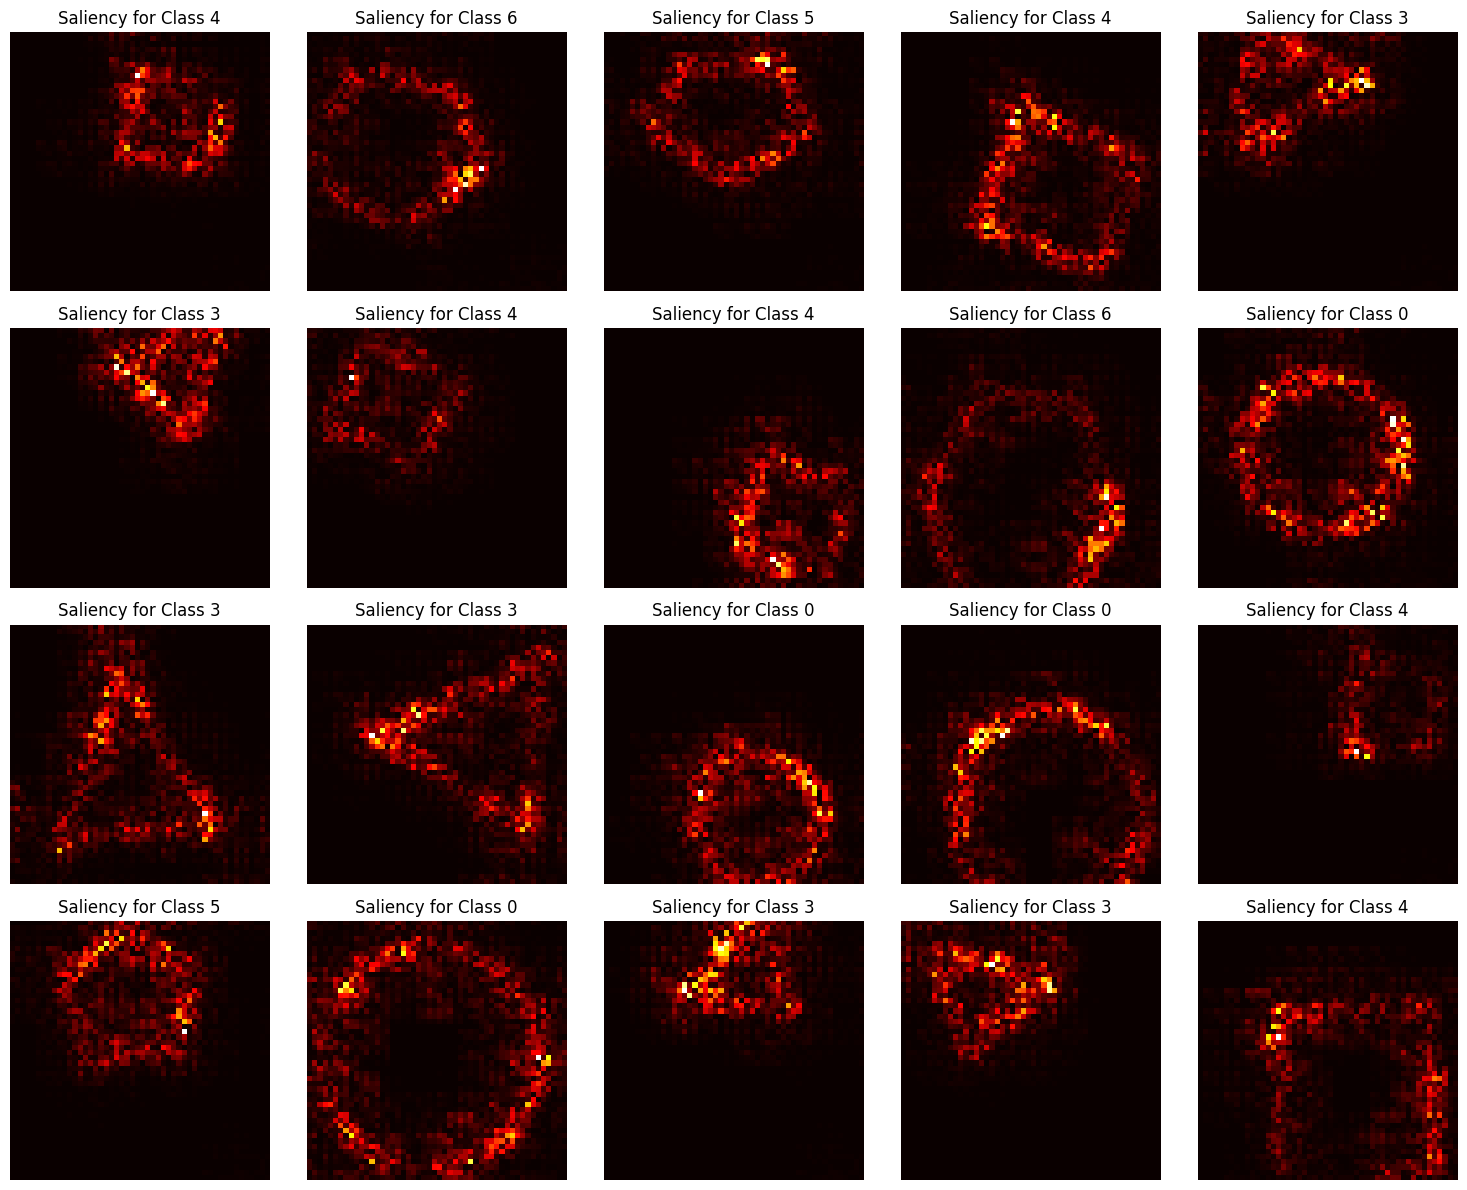

In [ ]:
from utils import saliency

saliency(model, flatland_dataset, num_images=20, device = device)


#Tikrinam su test data

In [ ]:
with gzip.open('flatland_test.data', 'rb') as f:
    X_test = pickle.load(f)

X_test = X_test[0]

print(X_test.shape)

(10000, 50, 50)


In [ ]:
model.eval()

predictions = []

with torch.no_grad():
    for image in X_test:
        image = Image.fromarray(np.uint8(image * 255))

        image_tensor = transform(image).unsqueeze(0).to(device).float()

        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

        predictions.append(predicted.item())

result_string = ''.join([str(int(p)) for p in predictions])

with open('flatland_predictions.txt', 'w') as f:
    f.write(result_string)

print("Predictions saved to 'flatland_predictions.txt'!")


Predictions saved to 'flatland_predictions.txt'!


#Išsaugojam modelį

In [ ]:
torch.save(model.state_dict(), 'model.pth')